# Mutual funds vs. Index drawdowns

Do active managers reduce drawdowns during downturns?

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

indices <- Indices()
mfi <- MutualFundsIndia()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Registering fonts with R

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package

2018 was a bad year. So lets look at the subsequent return profile of the top 5 midcap funds entring 2018 through June-2019.

In [2]:
lastAumDate <- (mfi$AumSchemewise() %>%
    filter(PERIOD <= as.Date('2018-01-01')) %>%
    summarize(MAX_TS = max(PERIOD)) %>%
    collect())$MAX_TS[1]

lastMetaDate <- (mfi$Meta() %>%
    filter(AS_OF >= lastAumDate) %>%
    summarize(MIN_TS = min(AS_OF)) %>%
    collect())$MIN_TS[1]

print(lastAumDate)
print(lastMetaDate)

topAum <- mfi$Meta() %>% 
    inner_join(mfi$AumSchemewise(), by="SCHEME_CODE") %>%
    filter(PERIOD == lastAumDate & AS_OF == lastMetaDate & CATEGORY %like% '%Mid-Cap%') %>%
    select(SCHEME_CODE, SCHEME_NAME, CATEGORY, AVG_AUM_WO_FOFD) %>%
    arrange(AVG_AUM_WO_FOFD) %>%
    top_n(10) %>%
    collect()

print(topAum)

Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

[1] "2017-12-01"
[1] "2018-03-24"


Selecting by AVG_AUM_WO_FOFD


# A tibble: 10 x 4
   SCHEME_CODE SCHEME_NAME                            CATEGORY   AVG_AUM_WO_FOFD
         <int> <chr>                                  <chr>                <dbl>
 1      105758 HDFC MID-CAP OPPORTUNITIES FUND - Gro… Small/Mid…        1503986.
 2      105989 DSP BlackRock Micro Cap Fund - Regula… Small/Mid…         485255.
 3      103360 Franklin India Smaller Companies Fund… Small/Mid…         480240.
 4      108594 IDFC Premier Equity Fund-Regular Plan… Small/Mid…         475372.
 5      101539 Sundaram Select Midcap-Growth          Small/Mid…         438527.
 6      113177 Reliance Small Cap Fund - Growth Plan… Small/Mid…         429950.
 7      100473 Franklin India Prima Fund-Growth       Small/Mid…         411091.
 8      104481 DSP BlackRock Small and Mid Cap Fund … Small/Mid…         376666.
 9      112932 Mirae Asset Emerging Bluechip Fund - … Small/Mid…         373978.
10      102941 SBI Magnum MIDCAP FUND - REGULAR PLAN… Small/Mid…         293322.


funds went through a re-classification exercise later in 2018. we will handpick those that retained their "mid-cap" status after the shuffle.

In [3]:
schemeCodes <- c(105758, 101539, 100473, 104481, 112932)

startDate <- as.Date("2018-01-01")
endDate <- as.Date("2019-06-30")

indexName <- "NIFTY MIDCAP 150 TR"

#get the daily returns of the funds
navXts <- NULL
for(sc in schemeCodes){
    navs <- data.frame(mfi$NavTimeSeries() %>%
        filter(SCHEME_CODE == sc & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        select(TIME_STAMP, NAV))
    
    navXts <- merge.xts(navXts, dailyReturn(xts(navs$NAV, navs$TIME_STAMP)))
}

#grab the benchmark
bm <- data.frame(indices$NseTimeSeries() %>%
    filter(NAME == indexName & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE))

navXts <- merge.xts(navXts, dailyReturn(xts(bm$CLOSE, bm$TIME_STAMP)))
names(navXts) <- c(schemeCodes, indexName)

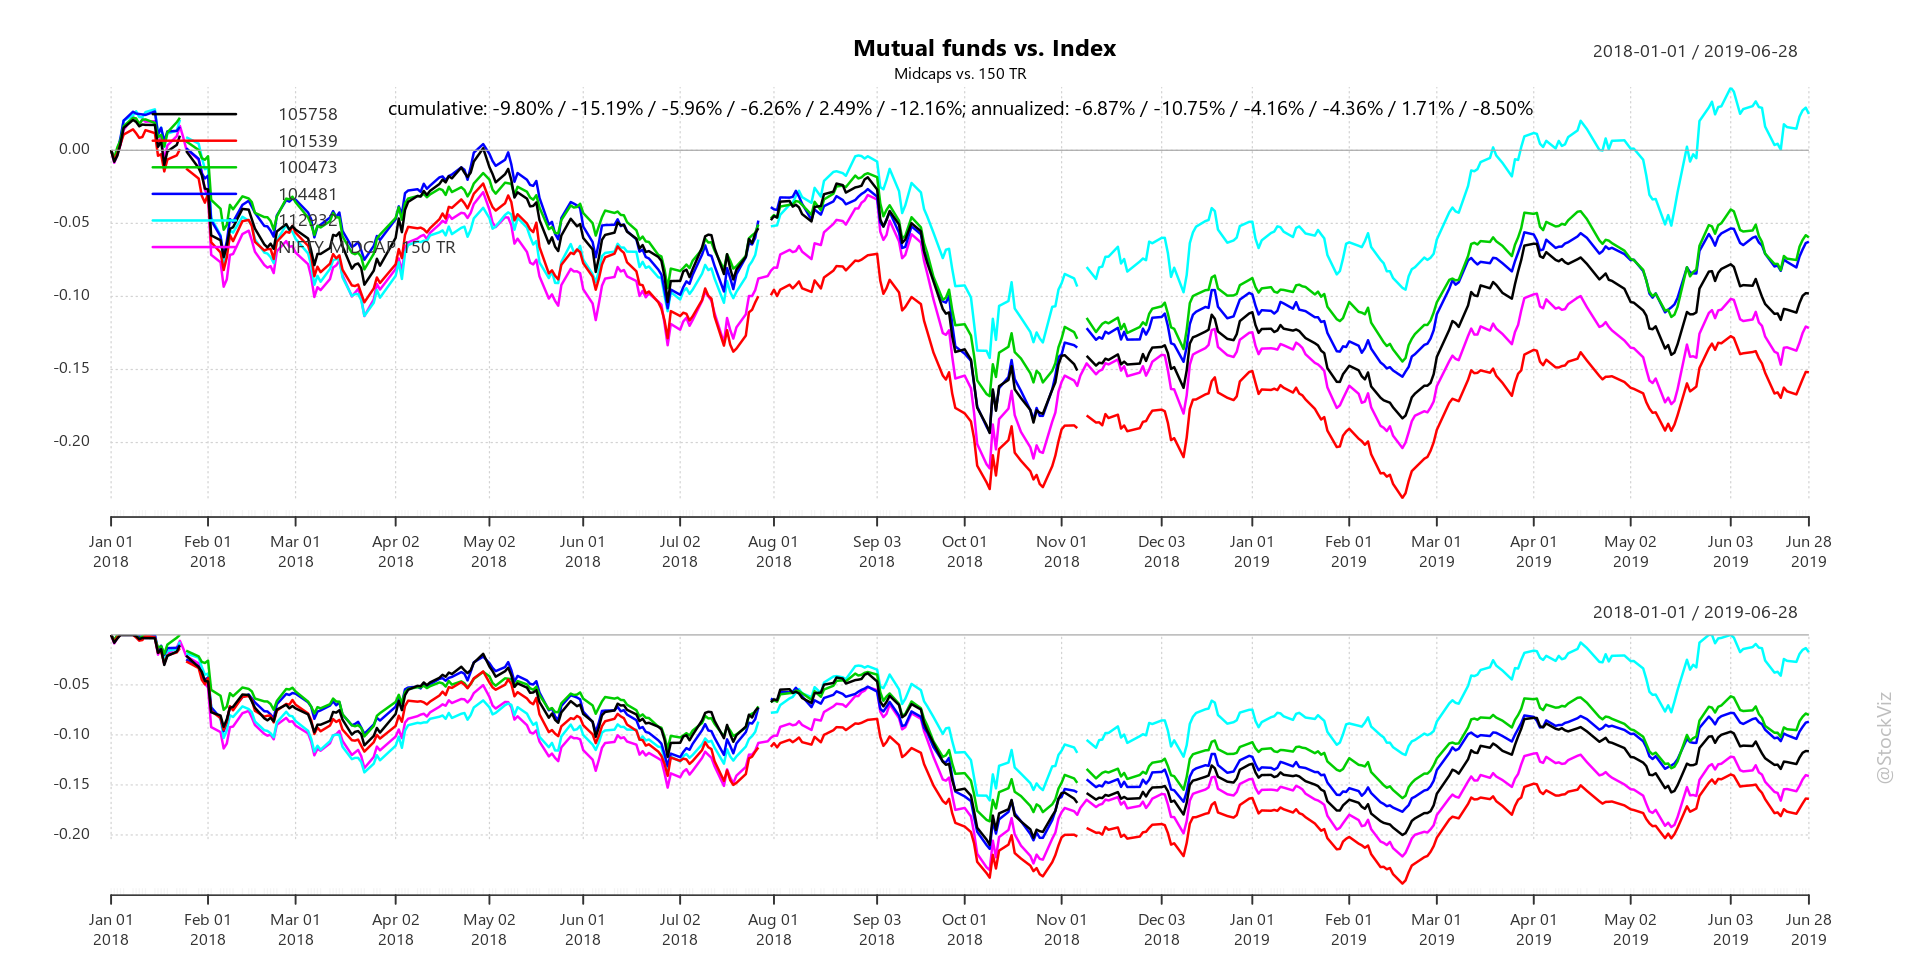

In [4]:
# plot the cumulative returns
Common.PlotCumReturns(navXts, "Mutual funds vs. Index", "Midcaps vs. 150 TR")


In [5]:
# legend
topAum %>%
    filter(SCHEME_CODE %in% schemeCodes) %>%
    select(SCHEME_CODE, SCHEME_NAME) %>%
    print()

# A tibble: 5 x 2
  SCHEME_CODE SCHEME_NAME                                                      
        <int> <chr>                                                            
1      105758 HDFC MID-CAP OPPORTUNITIES FUND - Growth Option                  
2      101539 Sundaram Select Midcap-Growth                                    
3      100473 Franklin India Prima Fund-Growth                                 
4      104481 DSP BlackRock Small and Mid Cap Fund - Regular Plan - Growth     
5      112932 Mirae Asset Emerging Bluechip Fund - Regular Plan - Growth Option


### take-away

It is impossible to eliminate drawdowns. However, going by the most recent one, fund managers above have shown skill in reducing drawdowns and bouncing back from it compared to the benchmark index.

Pause and reflect on this before you get carried away by Indian Bogleheads.

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)